In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
# http://pytorch.org/
!pip install -q torch torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5b43c000 @  0x7f23e5e491c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# Hyper-parameters
batch_size = 100

# Is cuda enabled?
cuda_enabled = torch.cuda.is_available()
print(f'CUDA enabled: {cuda_enabled}')

CUDA enabled: True


In [3]:
!curl -L https://www.dropbox.com/s/bp3nlci2h3y51f8/mnist.zip?dl=1 > mnist.zip && unzip -d data mnist.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.8M  100 14.8M    0     0  7609k      0  0:00:02  0:00:02 --:--:-- 15.1M
Archive:  mnist.zip
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/sample_submission.csv  


# Load data

In [0]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.train = train
        if self.train :
            dataset = pd.read_csv('./data/train.csv')
            self.Y = dataset.label.as_matrix().tolist()
            self.X = dataset.drop('label',axis=1).as_matrix().reshape(dataset.shape[0], 1, 28, 28)
        else:
            dataset = pd.read_csv('./data/test.csv')
            self.X = dataset.as_matrix().reshape(dataset.shape[0], 1, 28, 28)            
            
    def __getitem__(self, index):
        if self.train:
            return torch.Tensor(self.X[index].astype(float)),self.Y[index]
        else:
            return torch.Tensor(self.X[index].astype(float))
    
    def __len__(self):
        return self.X.shape[0]
    
    def inspect(self, idx=0):
        image = self.X[idx]
        plt.imshow(image.reshape(-1, self.X.shape[-1]))
        if self.train:
            plt.title(self.Y[idx])

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=Dataset(),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=Dataset(train=False),
                                          batch_size=batch_size,
                                          shuffle=False)

# Inspect our dataset

In [7]:
train_loader.dataset.X.shape, len(train_loader.dataset.Y)

((42000, 1, 28, 28), 42000)

In [8]:
test_loader.dataset.X.shape, len(train_loader.dataset.Y)

((28000, 1, 28, 28), 42000)

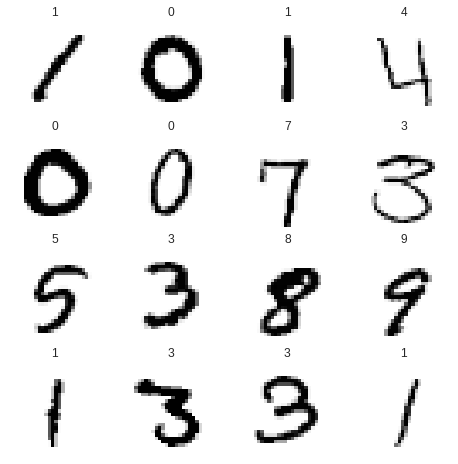

In [11]:
plt.figure(figsize=(8,8))
for i in range(16):
    ax = plt.subplot(4,4,1+i)
    train_loader.dataset.inspect(i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.show()

# CNN

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1 ,16, kernel_size=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def accuracy (outputs, labels): 
    return sum(outputs.detach().numpy().argmax(axis=1)
               ==labels.numpy())/len(labels)      

# Run the model

In [0]:
cnn = CNN()
if cuda_enabled:
    cnn.cuda()

In [0]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(cnn.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [90]:
%timeit
num_epochs = 10
for epoch in range(num_epochs):
    num_iters = len(train_loader.dataset)//batch_size
    sum_loss = 0
    sum_accu = 0
    for i, (images, labels) in enumerate(train_loader):
        if cuda_enabled:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
        else:
            images = Variable(images)
            labels = Variable(labels)            
        
        #Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        sum_accu += accuracy(outputs.cpu(), labels.cpu())

    print (f'Ep [{epoch+1}/{num_epochs}] '\
        f'Tl: {sum_loss/num_iters:.12f} '\
        f'Ac: {sum_accu/num_iters}', end='\n')

Ep [1/10] Tl: 0.000000000670 Ac: 1.0
Ep [2/10] Tl: 0.000000000653 Ac: 1.0
Ep [3/10] Tl: 0.000000000582 Ac: 1.0
Ep [4/10] Tl: 0.000000000525 Ac: 1.0
Ep [5/10] Tl: 0.000000000522 Ac: 1.0
Ep [6/10] Tl: 0.000000000315 Ac: 1.0
Ep [7/10] Tl: 0.000000000358 Ac: 1.0
Ep [8/10] Tl: 0.000000000397 Ac: 1.0
Ep [9/10] Tl: 0.000000000258 Ac: 1.0
Ep [10/10] Tl: 0.000000000219 Ac: 1.0


In [91]:
 cnn.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [0]:
ans = torch.cuda.LongTensor() if cuda_enabled else torch.LongTensor()  
for images in test_loader:
    images = Variable(images).cuda() if cuda_enabled else Variable(images)
    outputs = cnn(images)
    _,predicted = torch.max(outputs.data, 1)
    ans = torch.cat((ans,predicted),0)

In [93]:
aa = pd.DataFrame(ans.cpu().numpy())
aa.columns = ['Label']
Id = range(1,aa.size+1)
aa.insert(0, 'ImageId', Id)
aa.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [0]:
filename = 'submit_pytorch.csv' 
aa.to_csv(filename,index = False)
from google.colab import files
files.download(filename)